KeyboardInterrupt: 

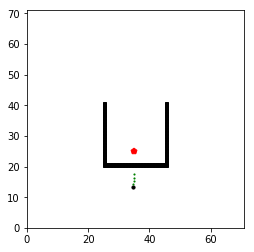

In [4]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time
import random
#from tkinter import *
from IPython import display
#import wx

# To replace the GUI:
algorithm = "COPE0"  # choose from: ["COPE0", "Bug1", "Bug2", "DistBug", "KBug", "TangentBug"]
obs = "U2"      # choose from: ["L", "U1", "U2", "pixelated", "T-corridor", "closed"]
n_agents = int(1)
runs = int(1)
extension1 = False   # for DistBug Algorithm
extension2 = False   # for DistBug Algorithm
extension3 = False   # for DistBug Algorithm
#####################

class Agent():
    def __init__(self, ID, xcor, ycor, destination):
        global algorithm
        self.ID = ID
        self.xcor = xcor
        self.ycor = ycor
        self.wspeed = 1
        self.destination = [destination[0]//1+0.5, destination[1]//1+0.5]
        self.follow_wall = False
        self.h = 'nobody'
        self.heading = 0
        self.d_min = 0
        self.r = size
        self.step = self.r
        self.br_dist = 0
        self.int_target = 'nobody'
        self.mline = []
        self.pre_node = []
        if random.randint(0, 1) == 0:
            self.direction = 1
        else:
            self.direction = -1
        self.face_target(self.destination)
        if algorithm == 'Bug2':
            self.create_mline()
        if algorithm == 'DistBug':
            self.cn = 0
            self.ext2 = False
            self.ext3 = False
            self.v_obs = []
        if algorithm == 'Bug1':
            self.l = 'nobody'
            self.search_mode = False
            self.r2 = 0
            self.r3 = 0
        if algorithm == 'KBug':
            self.step_forward = False
            self.node = 'nobody'
            if not self.target_visible(self.destination):
                self.h = self.find_wall(self.heading, self.r)
            else:
                self.h = 'nobody'
            self.last_node = 'nobody'
            if self.h != 'nobody':
                self.find_node()
                self.face_target(self.node)
        if algorithm == 'TangentBug':
            self.ltg_list = []
            self.transition1 = False
            self.transition2 = False

    def wall_p(self, angle, step):
        wall = 'nobody'
        x2 = (self.xcor//1+0.5 + np.cos(angle)*step)//1
        y2 = (self.ycor//1+0.5 + np.sin(angle)*step)//1
        if not all([(a > b) for a, b in zip([size, size], [x2, y2])]):
            wall = 'nobody'
        else:
            if patch_list[int(x2+y2*size)][2] == (0.0, 0.0, 0.0, 1.0):
                wall = [x2, y2]
        return wall

    def wall(self, angle, step):
        wall = 'nobody'
        x2 = (self.xcor + np.cos(angle)*step)//1
        y2 = (self.ycor + np.sin(angle)*step)//1
        if not all([(a > b) for a, b in zip([size, size], [x2, y2])]):
            wall = 'nobody'
        else:
            if patch_list[int(x2+y2*size)][2] == (0.0, 0.0, 0.0, 1.0):
                wall = [x2, y2]
        return wall

    def face_target(self, target):
        target = [target[0]//1+0.5, target[1]//1+0.5]
        if (target[0] - self.xcor) == 0:
            if (target[1] - self.ycor) > 0:
                self.heading = np.pi/2
            else:
                self.heading = -np.pi/2
        else:
            self.heading = np.arctan((target[1] - self.ycor) / (target[0] - self.xcor))
            if (target[0] - self.xcor) < 0:
                self.heading = self.heading + np.pi
        self.turn_positive(0)

    def fd(self, step):
        x2 = self.xcor + step*np.cos(self.heading)
        y2 = self.ycor + step*np.sin(self.heading)
        self.xcor = x2
        self.ycor = y2

    def target_visible(self, target):
        target = [target[0]//1+0.5, target[1]//1+0.5]
        direct = 0
        if (target[0] - self.xcor) == 0:
            if (target[1] - self.ycor) > 0:
                direct = np.pi/2
            else:
                direct = -np.pi/2
        else:
            direct = np.arctan((target[1] - self.ycor) / (target[0] - self.xcor))
            if (target[0] - self.xcor) < 0:
                direct = direct + np.pi
        m = 0
        output = False
        x2 = (self.xcor + m*np.cos(direct))//1
        y2 = (self.ycor + m*np.sin(direct))//1
        while m <= self.r and patch_list[int(x2+y2*size)][2] != (0.0, 0.0, 0.0, 1.0):
            if [x2,y2] == [target[0]//1, target[1]//1]:
                output = True
                m = self.r + 1
            else:
                m = m + self.wspeed
                x2 = (self.xcor + m * np.cos(direct)) // 1
                y2 = (self.ycor + m * np.sin(direct)) // 1
        return output

    def turn_positive(self, angle):
        self.heading = self.heading + angle
        if self.heading < 0:
            self.heading = 2*np.pi + self.heading
        elif self.heading >= 2*np.pi:
            self.heading = self.heading - 2*np.pi

    def create_mline(self):
        self.mline = []
        k = 0
        x2 = (self.xcor + np.cos(self.heading) * k) // 1
        y2 = (self.ycor + np.sin(self.heading) * k) // 1
        while [x2,y2] != [self.destination[0]//1, self.destination[1]//1]:
            self.mline.append([x2, y2])
            k += 1
            x2 = (self.xcor + np.cos(self.heading) * k) // 1
            y2 = (self.ycor + np.sin(self.heading) * k) // 1

    def build_v_obs(self, d):
        self.v_obs = []
        b = 0
        while b < 2*np.pi:
            x2 = (self.destination[0]+(d+1)*np.cos(b))//1
            y2 = (self.destination[1]+(d+1)*np.sin(b))//1
            if x2 <= size and y2 <= size:
                self.v_obs.append([x2, y2])
            b = b + 1/d

    def find_wall(self, direct, dist):
        m = 1
        while m <= dist:
            x2 = (self.xcor + m * np.cos(direct)) // 1
            y2 = (self.ycor + m * np.sin(direct)) // 1
            if x2 >= size or y2 >= size:
                m = dist + 1
            elif patch_list[int(x2 + y2 * size)][2] != (0.0, 0.0, 0.0, 1.0):
                m = m + self.wspeed
            else:
                output = [x2, y2]
                m = dist + 10
            if abs(m - dist) < 2:
                return 'nobody'
        return output

    def find_node(self):
        tmp = self.heading
        self.face_target(self.destination)
        tmp2 = self.heading
        self.h = self.find_wall(self.heading, self.r)
        self.heading = tmp
        x2 = (self.xcor + (distance2v([self.xcor, self.ycor], self.h) - 1) * np.cos(tmp2)) // 1
        y2 = (self.ycor + (distance2v([self.xcor, self.ycor], self.h) - 1) * np.sin(tmp2)) // 1
        hh = [x2 + 0.5, y2 + 0.5]
        lst = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                if patch_list[int((x2 + i) + (y2 + j) * size)][2] != (0.0, 0.0, 0.0, 1.0) and [self.xcor // 1,
                                                                                               self.ycor // 1] != [
                            x2 + i, y2 + j] and self.target_visible([hh[0] + i, hh[1] + j]):
                    nbrs = []
                    for s in [-1, 0, 1]:
                        for t in [-1, 0, 1]:
                            nbrs.append([x2 + i + s, y2 + j + t])
                    k = 0
                    ch = False
                    while k < len(nbrs) and ch is False:
                        if patch_list[int((nbrs[k][0]) + (nbrs[k][1]) * size)][2] == (0.0, 0.0, 0.0, 1.0):
                            ch = True
                        else:
                            k = k + 1
                    if ch is True:
                        lst.append([x2 + i, y2 + j])
        lyr = lst
        while lyr != []:
            ph = [self.xcor // 1, self.ycor // 1]
            a = []
            for f in range(len(lyr)):
                for m in [-1, 0, 1]:
                    for n in [-1, 0, 1]:  
                        nbrs = []
                        for m1 in [-1, 0, 1]:
                            for n1 in [-1, 0, 1]:
                                nbrs.append([lyr[f][0] + m + m1, lyr[f][1] + n + n1])
                        k = 0
                        ch = False
                        while k < len(nbrs) and ch is False:
                            if patch_list[int((nbrs[k][0]) + (nbrs[k][1]) * size)][2] == (0.0, 0.0, 0.0, 1.0):
                                ch = True
                            else:
                                k = k + 1
                        if ch is True:
                            if [lyr[f][0] + m, lyr[f][1] + n] != ph and \
                                            patch_list[int((lyr[f][0] + m) + (lyr[f][1] + n) * size)][2] != (
                                            0.0, 0.0, 0.0, 1.0) and not [lyr[f][0] + m, lyr[f][1] + n] in lst:
                                a.append([lyr[f][0] + m, lyr[f][1] + n])

            if a != []:
                a2 = []
                for i in range(len(a)):
                    if self.target_visible(a[i]):
                        a2.append(a[i])
            lyr = a2
            if lyr != []:
                lyr = np.unique(lyr, axis=0)
                lyr = lyr.tolist()
            lst = lst + lyr
            lst = np.unique(lst, axis=0)
            lst = lst.tolist()

        edge = lst
        head = tmp2
        rs = []
        for i in range(len(edge)):
            self.face_target(edge[i])
            if (self.heading - head) % (2 * np.pi) < np.pi:
                rs.append(edge[i])
        dist = []
        for i in range(len(rs)):
            dist.append(distance2v([self.xcor, self.ycor], rs[i]))
        dist2 = sorted(dist)
        rs2 = []
        for i in range(len(rs)):
            rs2.append(rs[dist.index(dist2[i])])

        a = 0
        node1 = 'nobody'
        for i in range(len(rs2)):
            self.face_target(rs2[i])
            b = (self.heading - head) % (2 * np.pi)
            if b >= a:
                node1 = rs2[i]
                a = b
            elif abs(b - a) < 10 / 180 * np.pi and distance2v([self.xcor, self.ycor], rs2[i]) > distance2v(
                    [self.xcor, self.ycor], node1):
                node1 = rs2[i]
                a = b

        ls = []
        for i in range(len(edge)):
            self.face_target(edge[i])
            if (self.heading - head) % (2 * np.pi) >= np.pi:
                ls.append(edge[i])
        dist = []
        for i in range(len(ls)):
            dist.append(distance2v([self.xcor, self.ycor], ls[i]))
        dist2 = sorted(dist)
        ls2 = []
        for i in range(len(ls)):
            ls2.append(ls[dist.index(dist2[i])])

        a = 2 * np.pi
        node2 = 'nobody'
        for i in range(len(ls2)):
            self.face_target(ls2[i])
            b = (self.heading - head) % (2 * np.pi)
            if b <= a:
                node2 = ls2[i]
                a = b
            elif abs(b - a) < 10 / 180 * np.pi and distance2v([self.xcor, self.ycor], ls2[i]) > distance2v(
                    [self.xcor, self.ycor], node2):
                node2 = ls2[i]
                a = b

        if node1 == 'nobody':
            self.node = node2
        elif node2 == 'nobody':
            self.node = node1
        elif distance2v([self.xcor // 1, self.ycor // 1], node1) < distance2v([self.xcor // 1, self.ycor // 1], node2):
            self.node = node1
        elif distance2v([self.xcor // 1, self.ycor // 1], node1) == distance2v([self.xcor // 1, self.ycor // 1], node2):
            if distance2v(self.destination, node1) < distance2v(self.destination, node2):
                self.node = node1
            else:
                self.node = node2
        else:
            self.node = node2

        if self.node == self.last_node:
            if self.node == node1:
                self.node = node2
            else:
                self.node = node1

    def walk_cope0(self):
        global size, n_agents_left, active_agents, n_trapped
        if self.follow_wall:
            c1 = self.wall_p(self.heading-np.pi/2*self.direction, 1)
            c2 = self.wall_p(self.heading-135/180*np.pi*self.direction, 1)
            if c1 == 'nobody' and c2 != 'nobody':
                if distance2v(c2, self.destination) > self.br_dist:
                    self.turn_positive(- self.direction * np.pi/2)
                else:
                    self.follow_wall = False
                    self.face_target(self.destination)
        next_step = self.wall(self.heading, self.wspeed)
        if next_step != 'nobody':
            if self.follow_wall:
                if self.wall(self.heading, 1) == [self.xcor//1, self.ycor//1] and self.wall(self.heading+self.direction*np.pi/2, 1) != 'nobody':
                    self.direction = -self.direction
                    self.turn_positive(np.pi)
                else:
                    while self.wall(self.heading, self.wspeed) != 'nobody':
                        self.turn_positive(self.direction*np.pi/2)
            else:
                self.follow_wall = True
                self.h = [self.xcor//1, self.ycor//1]
                self.d_min = distance2v([self.xcor, self.ycor], self.destination)
                self.int_target = next_step
                self.int_target = [self.int_target[0] // 1, self.int_target[1] // 1]
                n = self.wspeed + 1
                while patch_list[int(self.int_target[0]//1+(self.int_target[1]//1)*size)][2] == (0.0, 0.0, 0.0, 1.0):
                    self.int_target = [self.xcor + np.cos(self.heading)*n, self.ycor + np.sin(self.heading)*n]
                    self.int_target = [self.int_target[0] // 1, self.int_target[1] // 1]
                    n += 1
                self.br_dist = distance2v(self.int_target, self.destination)
# ##### extension 1
                if self.heading % (np.pi/2) == 0:
                    self.turn_positive(self.direction*np.pi/2)
                else:
                    horz = False
                    vert = False
                    if self.wall_p(np.pi/2, 1) != 'nobody' or self.wall_p(3*np.pi/2, 1) != 'nobody':
                        horz = True
                    if self.wall_p(np.pi, 1) != 'nobody' or self.wall_p(0, 1) != 'nobody':
                        vert = True
                    if horz and not vert:
                        if np.pi/2 < self.heading < 3*np.pi/2:
                            if self.heading < np.pi:
                                self.direction = 1
                            else:
                                self.direction = -1
                            self.heading = np.pi
                        else:
                            if self.heading < np.pi/2:
                                self.direction = -1
                            else:
                                self.direction = 1
                            self.heading = 0
                    if not horz and vert:
                        if np.pi < self.heading < 2*np.pi:
                            if self.heading < 3*np.pi/2:
                                self.direction = 1
                            else:
                                self.direction = -1
                            self.heading = 3*np.pi/2
                        else:
                            if self.heading < np.pi/2:
                                self.direction = 1
                            else:
                                self.direction = -1
                            self.heading = np.pi/2
                    if all([horz, vert]) or all([not horz, not vert]):
                        while self.wall(self.heading, self.wspeed) != 'nobody':
                            self.turn_positive(self.direction*44.8/180*np.pi)
                        if round(self.heading/(np.pi/2)) == 0 or round(self.heading/(np.pi/2)) == 4:
                            self.heading = 0
                        else:
                            if round(self.heading/(np.pi/2)) == 1:
                                self.heading = np.pi/2
                            else:
                                if round(self.heading/(np.pi/2)) == 2:
                                    self.heading = np.pi
                                else:
                                    self.heading = 3*np.pi/2

                while self.wall(self.heading, self.wspeed) != 'nobody':
                    self.turn_positive(self.direction*np.pi/2)

        if distance2v([self.xcor, self.ycor], self.destination) <= 1:
            self.xcor = self.destination[0]
            self.ycor = self.destination[1]
            n_agents_left += -1
            active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
            del self
        else:
            # people_ahead = {add code later}
            self.fd(self.wspeed)
            if self.follow_wall:
                if distance2v([self.xcor, self.ycor], self.destination) < self.d_min:
                    self.d_min = distance2v([self.xcor, self.ycor], self.destination)
                if self.target_visible(self.destination) or distance2v([self.xcor, self.ycor], self.destination) - self.r < self.d_min - self.step or [self.xcor//1,self.ycor//1] == self.int_target:
                    self.follow_wall = False
                    self.face_target(self.destination)
                    self.d_min = 0
                    self.h = 'nobody'
                x2 = (self.xcor + self.wspeed*np.cos(self.heading + np.pi))//1
                y2 = (self.ycor + self.wspeed*np.sin(self.heading + np.pi))//1
                if [self.xcor//1, self.ycor//1] == self.h and [x2,y2] != self.h:
                    active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                    del self
                    n_trapped += 1
                    n_agents_left -= 1
                elif [self.xcor//1+0.5, self.ycor//1+0.5] == self.destination:
                    active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                    del self
                    n_agents_left += -1

    def walk_bug1(self):
        global size, n_agents_left, active_agents, n_trapped
        if self.follow_wall:
            c1 = self.wall_p(self.heading - np.pi / 2 * self.direction, 1)
            c2 = self.wall_p(self.heading - 135 / 180 * np.pi * self.direction, 1)
            if c1 == 'nobody' and c2 != 'nobody':
                self.turn_positive(- self.direction * np.pi / 2)
        next_step = self.wall(self.heading, self.wspeed)
        if next_step != 'nobody':
            if self.follow_wall:
                if self.wall(self.heading, 1) == [self.xcor // 1, self.ycor // 1] and self.wall(
                                self.heading + self.direction * np.pi / 2, 1) != 'nobody':
                    self.direction = -self.direction
                    self.turn_positive(np.pi)
                else:
                    while self.wall(self.heading, self.wspeed) != 'nobody':
                        self.turn_positive(self.direction * np.pi / 2)
            else:
                self.search_mode = True
                self.follow_wall = True
                self.h = [self.xcor // 1, self.ycor // 1]
                self.q = distance2v([self.xcor, self.ycor], self.destination)
                self.l = [self.xcor // 1, self.ycor // 1]
                while self.wall(self.heading, self.wspeed) != 'nobody':
                    self.turn_positive(self.direction * 44.8 / 180 * np.pi)
                if round(self.heading / (np.pi / 2)) == 0 or round(self.heading / (np.pi / 2)) == 4:
                    self.heading = 0
                else:
                    if round(self.heading / (np.pi / 2)) == 1:
                        self.heading = np.pi / 2
                    else:
                        if round(self.heading / (np.pi / 2)) == 2:
                            self.heading = np.pi
                        else:
                            self.heading = 3 * np.pi / 2
                while self.wall(self.heading, self.wspeed) != 'nobody':
                    self.turn_positive(self.direction*np.pi / 2)
        if distance2v([self.xcor, self.ycor], self.destination) <= 1:
            self.xcor = self.destination[0]
            self.ycor = self.destination[1]
            n_agents_left += -1
            active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
            del self
        else:
            # people_ahead = {add code later}
            self.fd(self.wspeed)
            if self.search_mode:
                self.r2 = self.r2 + self.wspeed
                self.r3 = self.r3 + self.wspeed
                dist = distance2v([self.xcor, self.ycor], self.destination)
                if dist < self.q:
                    self.q = dist
                    self.l = [self.xcor // 1, self.ycor // 1]
                    self.r3 = 0
                x2 = (self.xcor + self.wspeed * np.cos(self.heading + np.pi)) // 1
                y2 = (self.ycor + self.wspeed * np.sin(self.heading + np.pi)) // 1
                if [self.xcor // 1, self.ycor // 1] == self.h and [x2, y2] != self.h and self.l != 'nobody':
                    self.search_mode = False
                    if self.r2 / 2 > self.r3:
                        self.turn_positive(np.pi)
                        self.direction = -self.direction
            else:
                if [self.xcor // 1, self.ycor // 1] == self.l:
                    self.follow_wall = False
                    self.search_mode = False
                    self.face_target(self.destination)
                    self.r2 = 0
                    self.r3 = 0
                    self.q = 0
                    self.h = 'nobody'
                    self.l = 'nobody'
                    next_step = self.wall(self.heading, self.wspeed)
                    if next_step != 'nobody':
                        active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                        del self
                        n_trapped += 1
                        n_agents_left -= 1
                    elif self.ID in active_agents and [self.xcor // 1 + 0.5, self.ycor // 1 + 0.5] == self.destination:
                        active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                        del self
                        n_agents_left += -1

    def walk_bug2(self):
        global size, n_agents_left, active_agents, n_trapped
        if self.follow_wall:
            c1 = self.wall_p(self.heading-np.pi/2*self.direction, 1)
            c2 = self.wall_p(self.heading-135/180*np.pi*self.direction, 1)
            if c1 == 'nobody' and c2 != 'nobody':
                self.turn_positive(- self.direction * np.pi/2)
        next_step = self.wall(self.heading, self.wspeed)
        if next_step != 'nobody':
            if self.follow_wall:
                if self.wall(self.heading, 1) == [self.xcor//1, self.ycor//1] and self.wall(self.heading+self.direction*np.pi/2, 1) != 'nobody':
                    self.direction = -self.direction
                    self.turn_positive(np.pi)
                else:
                    while self.wall(self.heading, self.wspeed) != 'nobody':
                        self.turn_positive(self.direction*np.pi/2)
            else:
                self.follow_wall = True
                self.h = [self.xcor//1, self.ycor//1]
                while self.wall(self.heading, self.wspeed) != 'nobody':
                    self.turn_positive(self.direction*44.8/180*np.pi)
                if round(self.heading/(np.pi/2)) == 0 or round(self.heading/(np.pi/2)) == 4:
                    self.heading = 0
                else:
                    if round(self.heading/(np.pi/2)) == 1:
                        self.heading = np.pi/2
                    else:
                        if round(self.heading/(np.pi/2)) == 2:
                            self.heading = np.pi
                        else:
                            self.heading = 3*np.pi/2
                while self.wall(self.heading, self.wspeed) != 'nobody':
                    self.turn_positive(self.direction*np.pi/2)
        if distance2v([self.xcor, self.ycor], self.destination) <= 1:
            self.xcor = self.destination[0]
            self.ycor = self.destination[1]
            n_agents_left += -1
            active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
            del self
        else:
            # people_ahead = {add code later}
            self.fd(self.wspeed)
            if self.follow_wall:
                x2 = (self.xcor + np.cos(self.heading)) // 1
                y2 = (self.ycor + np.sin(self.heading)) // 1
                if [self.xcor//1, self.ycor//1] in self.mline and [self.xcor//1, self.ycor//1] != self.h and [x2, y2] != self.h and distance2v([self.xcor, self.ycor], self.destination) < distance2v(self.h, self.destination):
                    self.follow_wall = False
                    self.face_target(self.destination)
                    self.h = 'nobody'
                x2 = (self.xcor + self.wspeed*np.cos(self.heading + np.pi))//1
                y2 = (self.ycor + self.wspeed*np.sin(self.heading + np.pi))//1
                if [self.xcor//1, self.ycor//1] == self.h and [x2, y2] != self.h:
                    active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                    del self
                    n_trapped += 1
                    n_agents_left -= 1
                elif [self.xcor//1+0.5, self.ycor//1+0.5] == self.destination:
                    active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                    del self
                    n_agents_left += -1

    def walk_distbug(self):
        global size, n_agents_left, active_agents, n_trapped
        if self.follow_wall:
            # ### extension 2
            if extension2:
                if not self.ext2:
                    angle = 0
                    if (self.destination[0] - self.xcor) == 0:
                        if (self.destination[1] - self.ycor) > 0:
                            angle = np.pi / 2
                        else:
                            angle = -np.pi / 2
                    else:
                        angle = np.arctan((self.destination[1] - self.ycor) / (self.destination[0] - self.xcor))
                        if (self.destination[0] - self.xcor) < 0:
                            angle = angle + np.pi
                    if angle < 0:
                        angle = 2 * np.pi + angle
                    elif angle >= 2 * np.pi:
                        angle = angle - 2 * np.pi
                    if np.abs(angle) > np.pi:
                        angle = 2 * np.pi - angle
                    if angle > 135 / 180 * np.pi:
                        self.direction = -self.direction
                        self.turn_positive(np.pi)
                        self.ext2 = True
                        ###########
            c1 = self.wall_p(self.heading - np.pi / 2 * self.direction, 1)
            c2 = self.wall_p(self.heading - 135 / 180 * np.pi * self.direction, 1)
            if c1 == 'nobody' and c2 != 'nobody':
                self.turn_positive(- self.direction * np.pi / 2)
        next_step = self.wall(self.heading, self.wspeed)
        if next_step != 'nobody':
            if self.follow_wall:
                if self.wall(self.heading, 1) == [self.xcor // 1, self.ycor // 1] and self.wall(
                                self.heading + self.direction * np.pi / 2, 1) != 'nobody':
                    self.direction = -self.direction
                    self.turn_positive(np.pi)
                else:
                    while self.wall(self.heading, self.wspeed) != 'nobody':
                        self.turn_positive(self.direction * np.pi / 2)
            else:
                self.follow_wall = True
                self.h = [self.xcor // 1, self.ycor // 1]
                self.create_mline()
                self.d_min = distance2v([self.xcor, self.ycor], self.destination)
                if extension3:
                    self.build_v_obs(distance2v([self.xcor, self.ycor], self.destination))
                # ##### extension 1
                if extension1:
                    if self.heading % (np.pi / 2) == 0:
                        self.turn_positive(self.direction * np.pi / 2)
                    else:
                        horz = False
                        vert = False
                        if self.wall_p(np.pi / 2, 1) != 'nobody' or self.wall_p(3 * np.pi / 2, 1) != 'nobody':
                            horz = True
                        if self.wall_p(np.pi, 1) != 'nobody' or self.wall_p(0, 1) != 'nobody':
                            vert = True
                        if horz and not vert:
                            if np.pi / 2 < self.heading < 3 * np.pi / 2:
                                if self.heading < np.pi:
                                    self.direction = 1
                                else:
                                    self.direction = -1
                                self.heading = np.pi
                            else:
                                if self.heading < np.pi / 2:
                                    self.direction = -1
                                else:
                                    self.direction = 1
                                self.heading = 0
                        if not horz and vert:
                            if np.pi < self.heading < 2 * np.pi:
                                if self.heading < 3 * np.pi / 2:
                                    self.direction = 1
                                else:
                                    self.direction = -1
                                self.heading = 3 * np.pi / 2
                            else:
                                if self.heading < np.pi / 2:
                                    self.direction = 1
                                else:
                                    self.direction = -1
                                self.heading = np.pi / 2
                        if all([horz, vert]) or all([not horz, not vert]):
                            while self.wall(self.heading, self.wspeed) != 'nobody':
                                self.turn_positive(self.direction * 44.8 / 180 * np.pi)
                            if round(self.heading / (np.pi / 2)) == 0 or round(self.heading / (np.pi / 2)) == 4:
                                self.heading = 0
                            else:
                                if round(self.heading / (np.pi / 2)) == 1:
                                    self.heading = np.pi / 2
                                else:
                                    if round(self.heading / (np.pi / 2)) == 2:
                                        self.heading = np.pi
                                    else:
                                        self.heading = 3 * np.pi / 2

                            while self.wall(self.heading, self.wspeed) != 'nobody':
                                self.turn_positive(self.direction*np.pi / 2)

                    while self.wall(self.heading, self.wspeed) != 'nobody':
                        self.turn_positive(self.direction*np.pi / 2)
                else:
                    while self.wall(self.heading, self.wspeed) != 'nobody':
                        self.turn_positive(self.direction * 44.8 / 180 * np.pi)
                    if round(self.heading / (np.pi / 2)) == 0 or round(self.heading / (np.pi / 2)) == 4:
                        self.heading = 0
                    else:
                        if round(self.heading / (np.pi / 2)) == 1:
                            self.heading = np.pi / 2
                        else:
                            if round(self.heading / (np.pi / 2)) == 2:
                                self.heading = np.pi
                            else:
                                self.heading = 3 * np.pi / 2
                    while self.wall(self.heading, self.wspeed) != 'nobody':
                        self.turn_positive(self.direction*np.pi / 2)

        if distance2v([self.xcor, self.ycor], self.destination) <= 1:
            self.xcor = self.destination[0]
            self.ycor = self.destination[1]
            n_agents_left += -1
            active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
            del self
        else:
            # people_ahead = {add code later}
            self.fd(self.wspeed)
            if self.follow_wall:
                if extension3:
                    if [self.xcor // 1, self.ycor // 1] in self.v_obs:
                        if self.ext3:
                            self.build_v_obs(distance2v([self.xcor, self.ycor], self.destination) + self.r / 2)
                            self.ext3 = False
                        else:
                            self.direction = -self.direction
                            self.turn_positive(np.pi)
                            self.ext3 = True
                            c1 = self.wall_p(self.heading - np.pi / 2 * self.direction, 1)
                            c2 = self.wall_p(self.heading - 135 / 180 * np.pi * self.direction, 1)
                            if c1 == 'nobody' and c2 != 'nobody':
                                self.fd(self.wspeed)

                if distance2v([self.xcor, self.ycor], self.destination) < self.d_min:
                    self.d_min = distance2v([self.xcor, self.ycor], self.destination)
                if self.target_visible(self.destination) or distance2v(
                        [self.xcor, self.ycor], self.destination) - self.r < self.d_min - self.step or (
                            [self.xcor // 1, self.ycor // 1] in self.mline and [self.xcor // 1,
                                                                                 self.ycor // 1] != self.h and distance2v(
                    [self.xcor // 1, self.ycor // 1], self.destination) < distance2v(self.h, self.destination)):
                    self.follow_wall = False
                    self.face_target(self.destination)
                    self.d_min = 0
                    self.h = 'nobody'
                    self.mline = []
                    self.ext2 = False
                    self.cn = 0
                    self.ext3 = False
                    self.v_obs = []
                x2 = (self.xcor + self.wspeed * np.cos(self.heading + np.pi)) // 1
                y2 = (self.ycor + self.wspeed * np.sin(self.heading + np.pi)) // 1
                if [self.xcor // 1, self.ycor // 1] == self.h and [x2, y2] != self.h:
                    if self.cn == 1 or (self.ext3 is False and extension3 is True and extension2 is False) or (
                            extension3 is False and extension2 is False):
                        active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                        del self
                        n_trapped += 1
                        n_agents_left -= 1
                    else:
                        self.cn = 1
                elif [self.xcor // 1 + 0.5, self.ycor // 1 + 0.5] == self.destination:
                    active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                    del self
                    n_agents_left += -1

    def walk_kbug(self):
        global size, n_agents_left, active_agents, n_trapped
        self.step_forward = False
        tmp = self.heading
        self.face_target(self.destination)
        tmp2 = self.heading
        if self.find_wall(self.heading, self.r) != 'nobody' and self.node == 'nobody':
            self.node = [self.xcor // 1, self.ycor // 1]
        self.heading = tmp
        if [self.xcor // 1, self.ycor // 1] != self.node:
            self.step_forward = True
        else:
            self.node = 'nobody'
            if self.target_visible(self.destination) or self.find_wall(tmp2, self.r) == 'nobody':
                self.face_target(self.destination)
                self.step_forward = True
            else:
                self.find_node()
                self.last_node = [self.xcor // 1, self.ycor // 1]
                self.face_target(self.node)
                self.step_forward = True

        if self.step_forward:
            # add human interaction
            self.fd(self.wspeed)
        if [self.xcor // 1 + 0.5, self.ycor // 1 + 0.5] == self.destination:
            active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
            del self
            n_agents_left += -1

    def walk_tangent(self):
        if self.transition1:
            if [self.xcor // 1, self.ycor // 1] != self.h:
                self.fd(self.wspeed)
            else:
                self.transition1 = False
                self.follow_wall = True
                while self.wall(self.heading, self.wspeed) != 'nobody':
                    self.turn_positive(self.direction * 44.5 / 180 * np.pi)
                if round(self.heading / (np.pi / 2)) == 0 or round(self.heading / (np.pi / 2)) == 4:
                    self.heading = 0
                elif round(self.heading / (np.pi / 2)) == 1:
                    self.heading = np.pi / 2
                elif round(self.heading / (np.pi / 2)) == 2:
                    self.heading = np.pi
                else:
                    self.heading = 3 * np.pi / 2
        else:
            if self.transition2:
                if distance2v([self.xcor, self.ycor], [self.destination]) <= self.d_min:
                    self.face_target(self.destination)
                    self.transition2 = False
                    self.h = 'nobody'
                else:
                    self.fd(self.wspeed)
            else:
                if self.follow_wall:
                    self.follow_boundry()
                else:
                    self.motion_toward_target()

    def follow_boundry(self):
        self.LTG()
        c1 = self.wall_p(self.heading - np.pi / 2 * self.direction, 1)
        c2 = self.wall_p(self.heading - 135 / 180 * np.pi * self.direction, 1)
        if c1 == 'nobody' and c2 != 'nobody':
            self.turn_positive(- self.direction * np.pi / 2)
        next_step = self.wall(self.heading, self.wspeed)
        if next_step != 'nobody':
            if self.wall(self.heading, 1) == [self.xcor // 1, self.ycor // 1] and self.wall(
                            self.heading + self.direction * np.pi / 2, 1) != 'nobody':
                self.direction = -self.direction
                self.turn_positive(np.pi)
            else:
                while self.wall(self.heading, self.wspeed) != 'nobody':
                    self.turn_positive(self.direction * np.pi / 2)
                tmp = self.heading
                self.face_target(self.destination)
                if self.target_visible(self.destination) or self.find_wall(self.heading, self.r) == 'nobody':
                    self.follow_wall = False
                    self.h = 'nobody'
                else:
                    self.heading = tmp
        else:
            if distance2v([self.xcor, self.ycor], self.destination) <= 1:
                self.xcor = self.destination[0]
                self.ycor = self.destination[1]
                n_agents_left += -1
                active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                del self
            # add human interaction
            self.fd(self.wspeed)
            if distance2v([self.xcor, self.ycor], self.destination) < self.d_min:
                self.d_min = distance2v([self.xcor, self.ycor], self.destination)
            x2 = (self.xcor + self.wspeed * np.cos(self.heading + np.pi)) // 1
            y2 = (self.ycor + self.wspeed * np.sin(self.heading + np.pi)) // 1
            if [self.xcor // 1, self.ycor // 1] == self.h and [x2, y2] != self.h:
                active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                del self
                n_trapped += 1
                n_agents_left -= 1
            elif [self.xcor // 1, self.ycor // 1] == self.destination:
                active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
                del self
                n_agents_left += -1
            else:
                dist = size * 2
                node = []
                for i in range(len(self.ltg_list)):
                    dist2 = distance2v(self.ltg_list[i], self.destination)
                    if dist2 < dist:
                        node = self.ltg_list[i]
                        dist = dist2
                print(node[0]-35, node[1]-35)
                if distance2v(node, self.destination) < self.d_min:
                    self.follow_wall = False
                    self.transition2 = True
                    self.face_target(node)

                tmp = self.heading
                self.face_target(self.destination)
                if self.target_visible(self.destination) or self.find_wall(self.heading, self.r) == 'nobody':
                    self.follow_wall = False
                    self.h = 'nobody'
                else:
                    self.heading = tmp

    def motion_toward_target(self):
        if [self.xcor // 1, self.ycor // 1] == self.destination:
            n_agents_left += -1
            active_agents = np.delete(active_agents, np.nonzero(active_agents == self.ID)[0][0])
            del self
        else:
            tmp = self.heading
            self.face_target(self.destination)
            if self.target_visible(self.destination) or self.find_wall(self.heading, self.r) == 'nobody':
                # add human interaction
                self.fd(self.wspeed)
            else:
                self.heading = tmp
                self.LTG()
                dist = size * 2
                node = []
                for i in range(len(self.ltg_list)):
                    dist2 = distance2v(self.ltg_list[i], self.destination) + distance2v(self.ltg_list[i], [self.xcor//1, self.ycor//1])
                    if dist2 < dist:
                        node = self.ltg_list[i]
                        dist = dist2
                self.face_target(node)
                if distance2v(node, self.destination) >= distance2v([self.xcor, self.ycor], self.destination):
                    self.h = node
                    tmp = self.heading
                    self.face_target(self.destination)
                    tmp2 = self.find_wall(self.heading, self.r)
                    self.heading = tmp
                    self.dmin = distance2v(tmp2, self.destination)
                    if node[0] < tmp2[0] or node[1] > tmp2[1]:
                        self.direction = 1
                    else:
                        self.direction = -1
                    self.transition1 = True
                else:
                    next_step = self.wall(self.heading, self.wspeed)
                    if next_step != 'nobody':
                        dist = size * 2
                        tmp = []
                        for s in [-1, 0, 1]:
                            for t in [-1, 0, 1]:
                                dist2 = distance2v([self.xcor // 1 + s, self.ycor // 1 + t], [self.destination])
                                if patch_list[int((self.xcor // 1 + s) + (self.ycor // 1 + t) * size)][2] != (
                                        0.0, 0.0, 0.0, 1.0) and dist2 < dist:
                                    tmp = [self.xcor // 1 + s, self.ycor // 1 + t]
                                    dist = dist2
                        self.xcor = tmp[0]
                        self.ycor = tmp[1]
                    else:
                        self.fd(self.wspeed)

    def LTG(self):
        self.ltg_list = []
        tmp = self.heading
        self.face_target(self.destination)
        direct = self.heading
        self.heading = tmp
        if self.find_wall(direct, self.r) == 'nobody':
            x2 = (self.xcor + self.wspeed * np.cos(self.heading + direct)) // 1
            y2 = (self.ycor + self.wspeed * np.sin(self.heading + direct)) // 1
            self.ltg_list.append([x2, y2])
        vis = []
        for s in range(-(int(self.r)), int(self.r) + 1):
            for t in range(-(int(self.r)), int(self.r) + 1):
                if s != 0 or t != 0:
                    if 0 <= (self.xcor // 1 + s) < size and 0 <= (self.ycor // 1 + t) < size:
                        if distance2v([self.xcor, self.ycor],
                                      [self.xcor // 1 + s, self.ycor // 1 + t]) < self.r and self.target_visible(
                            [self.xcor // 1 + s, self.ycor // 1 + t]):
                            vis.append([self.xcor // 1 + s, self.ycor // 1 + t])
        edge1 = []
        for i in vis:
            nbrs = []
            for s in [-1, 0, 1]:
                for t in [-1, 0, 1]:
                    if (s != 0 or t != 0) and (
                                        i[0] + s < size and i[0] + s >= 0 and i[1] + t < size and i[1] + t >= 0):
                        nbrs.append([i[0] + s, i[1] + t])
            k = 0
            ch = False
            while k < len(nbrs) and ch is False:
                if patch_list[int((nbrs[k][0]) + (nbrs[k][1]) * size)][2] == (0.0, 0.0, 0.0, 1.0):
                    ch = True
                else:
                    k = k + 1
            if ch is True:
                edge1.append(i)

        for i in edge1:
            count = 0
            for s in [-1, 0, 1]:
                for t in [-1, 0, 1]:
                    if (s == 0 or t == 0) and (s != 0 or t != 0):
                        if [i[0] + s, i[1] + t] in edge1:
                            count += 1
            if count == 1:
                self.ltg_list.append(i)
        self.ltg_list = np.unique(self.ltg_list, axis=0)
        self.ltg_list = self.ltg_list.tolist()


def distance2v(p1,p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


# ########### GUI (wxpython) #############
# class MyFrame(wx.Frame):
#     def __init__(self, *args, **kwds):
#         kwds["style"] = kwds.get("style", 0) | wx.DEFAULT_FRAME_STYLE
#         wx.Frame.__init__(self, *args, **kwds)
#         self.SetSize((385, 385))
#         self.choice_2 = wx.Choice(self, wx.ID_ANY, choices=["L", "U1", "U2", "pixelated", "T-corridor", "closed"])
#         self.checkbox_1 = wx.CheckBox(self, wx.ID_ANY, "Extension 1")
#         self.checkbox_2 = wx.CheckBox(self, wx.ID_ANY, "Extension 2")
#         self.choice_1 = wx.Choice(self, wx.ID_ANY, choices=["COPE0", "Bug1", "Bug2", "DistBug", "KBug", "TangentBug"])
#         self.checkbox_3 = wx.CheckBox(self, wx.ID_ANY, "Extension 3")
#         self.text_ctrl_1 = wx.TextCtrl(self, wx.ID_ANY, "1")
#         self.button_1 = wx.Button(self, wx.ID_ANY, "GO!")
#         self.text_ctrl_2 = wx.TextCtrl(self, wx.ID_ANY, "1")
#         self.button_2 = wx.Button(self, wx.ID_CLOSE, "")

#         self.__set_properties()
#         self.__do_layout()

#         self.button_1.Bind(wx.EVT_BUTTON, self.ongo)
#         self.button_2.Bind(wx.EVT_BUTTON, self.onclose)
#         # end wxGlade

#     def onclose(self, event):
#         self.Close()
#         quit()

#     def ongo(self, event):
#         global algorithm, obs, n_agents, runs, extension1, extension2, extension3
#         algorithm = self.choice_1.GetString(self.choice_1.GetSelection())
#         obs = self.choice_2.GetString(self.choice_2.GetSelection())
#         n_agents = int(self.text_ctrl_1.GetValue())
#         runs = int(self.text_ctrl_2.GetValue())
#         extension1 = self.checkbox_1.GetValue()
#         extension2 = self.checkbox_2.GetValue()
#         extension3 = self.checkbox_3.GetValue()
#         self.Close()

#     def __set_properties(self):
#         # begin wxGlade: MyFrame.__set_properties
#         self.SetTitle("frame")
#         self.choice_2.SetMinSize((110, 25))
#         self.choice_2.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         self.choice_2.SetSelection(0)
#         self.checkbox_1.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         self.checkbox_2.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         self.choice_1.SetMinSize((115, 25))
#         self.choice_1.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         self.choice_1.SetSelection(0)
#         self.checkbox_3.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         self.text_ctrl_1.SetMinSize((100, 25))
#         self.text_ctrl_1.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         self.button_1.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         self.text_ctrl_2.SetMinSize((100, 25))
#         self.text_ctrl_2.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         self.button_2.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         # end wxGlade

#     def __do_layout(self):
#         # begin wxGlade: MyFrame.__do_layout
#         sizer_1 = wx.BoxSizer(wx.VERTICAL)
#         grid_sizer_1 = wx.GridSizer(12, 2, 0, 0)
#         label_1 = wx.StaticText(self, wx.ID_ANY, "Choose obstacle")
#         label_1.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         grid_sizer_1.Add(label_1, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         grid_sizer_1.Add(self.choice_2, 0, wx.ALIGN_CENTER, 0)
#         label_5 = wx.StaticText(self, wx.ID_ANY, "For DistBug:")
#         label_5.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         grid_sizer_1.Add(label_5, 0, 0, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         grid_sizer_1.Add(self.checkbox_1, 0, 0, 0)
#         label_2 = wx.StaticText(self, wx.ID_ANY, "Choose algorithm")
#         label_2.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         grid_sizer_1.Add(label_2, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add(self.checkbox_2, 0, 0, 0)
#         grid_sizer_1.Add(self.choice_1, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add(self.checkbox_3, 0, 0, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         label_3 = wx.StaticText(self, wx.ID_ANY, "Number of agents")
#         label_3.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         grid_sizer_1.Add(label_3, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         grid_sizer_1.Add(self.text_ctrl_1, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add(self.button_1, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         label_4 = wx.StaticText(self, wx.ID_ANY, "Number of runs")
#         label_4.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL, 0, ""))
#         grid_sizer_1.Add(label_4, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         grid_sizer_1.Add(self.text_ctrl_2, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add(self.button_2, 0, wx.ALIGN_CENTER, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         grid_sizer_1.Add((0, 0), 0, 0, 0)
#         sizer_1.Add(grid_sizer_1, 1, wx.EXPAND, 0)
#         self.SetSizer(sizer_1)
#         self.Layout()
#         # end wxGlade
# # end of class MyFrame


# class MyApp(wx.App):
#     def OnInit(self):
#         self.frame = MyFrame(None, wx.ID_ANY, "")
#         self.SetTopWindow(self.frame)
#         self.frame.Show()
#         return True


# app = MyApp(0)
# app.MainLoop()
# #######

# ########### GUI (tkinter) #############
# root = Tk()
# # root.geometry('270x140')
# root.title("Input parameters")
# # Create a Tkinter variable
# tkvar = StringVar(root)
# # Dictionary with options
# obs_options = ['L', 'U1', 'U2', 'pixelated', 'T-corridor', 'closed']
# tkvar.set(obs_options[0])  # set the default option
# popupMenu = OptionMenu(root, tkvar, *obs_options)
# Label(root, text="Choose obstacle").grid(row=1, column=1)
# popupMenu.grid(row=2, column=1)

# tkvar2 = StringVar(root)
# alg_options = ['COPE0', 'Bug2', 'DistBug', 'Bug1', 'KBug', 'TangentBug']
# tkvar2.set(alg_options[0])  # set the default option
# popupMenu2 = OptionMenu(root, tkvar2, *alg_options)
# Label(root, text="Choose algorithm").grid(row=3, column=1)
# popupMenu2.grid(row=4, column=1)

# var1 = IntVar()
# var2 = IntVar()
# var3 = IntVar()
# Label(root, text="For DistBug:").grid(row=2, column=2)
# c1 = Checkbutton(root, text="Extension 1", variable=var1)
# c1.grid(row=3, column=2, columnspan=2, sticky=W, padx=10)
# c2 = Checkbutton(root, text="Extension 2", variable=var2)
# c2.grid(row=4, column=2, columnspan=2, sticky=W, padx=10)
# c3 = Checkbutton(root, text="Extension 3", variable=var3)
# c3.grid(row=5, column=2, columnspan=2, sticky=W, padx=10)

# x = StringVar()
# x.set('1')
# e1 = Entry(root, textvariable=x)
# Label(root, text="Number of agents").grid(row=5, column=1)
# e1.grid(row=6, column=1)
# x2 = StringVar()
# x2.set('1')
# e2 = Entry(root, textvariable=x2)
# Label(root, text="Number of runs").grid(row=7, column=1)
# e2.grid(row=8, column=1)

# Button(root, text='     GO!     ', command=root.quit).grid(row=10, column=0, sticky=W, padx=10, pady=10)
# Button(root, text='     Quit     ', command=root.destroy).grid(row=10, column=2, sticky=W, padx = 10, pady=10)

# root.mainloop()

# ################## input data ##################################
# obs = "L"
# n_agents = int(1)
# runs = int(1)
# algorithm = "COPE0"
# extension1 = False
# extension2 = False
# extension3 = False
# root.destroy()

size = 71
if obs == 'L' or obs == 'pixelated' or obs == 'T-corridor':
    destination = [35,60] # top
elif obs == 'U1':
    destination = [35,10] # down
elif obs == 'closed':
    destination = [35,35] # trapped
else:
    destination = [35,25]  # middle


# ####### Build geometry ###########
patch_list = []
fig, ax = plt.subplots()
plt.ion()
if obs == 'L':
    for j in range(size):
        for i in range(size):
            patch_list.append([i,j])
            if (j == 25 and 10 <= i <= 60) or (i == 10 and 25 <= j <= 50):
                p = patches.Rectangle((i, j), 1, 1, color='black')
                ax.add_patch(p)
            else:
                p = patches.Rectangle((i, j), 1, 1, color='white')
            patch_list[len(patch_list)-1].append(p.get_facecolor())

elif obs == 'U1' or obs == 'U2':
    for j in range(size):
        for i in range(size):
            patch_list.append([i, j])
            if (j == 20 and 25 <= i <= 45) or (i == 25 and 20 <= j <= 40) or (i == 45 and 20 <= j <= 40):
                p = patches.Rectangle((i, j), 1, 1, color='black')
                ax.add_patch(p)
            else:
                p = patches.Rectangle((i, j), 1, 1, color='white')
            patch_list[len(patch_list)-1].append(p.get_facecolor())

elif obs == 'pixelated':
    for j in range(size):
        for i in range(size):
            patch_list.append([i,j])
            if (0.6*i+14) <= j <= 50 and 10 <= i <= 60:  # or (i>=10 and j>=20 and j<=50) and (j>-0.6*i+14):
                if (j > 0.6*i+15) or (j == 0.6*i+14 and random.randint(0, 1) == 1):
                    p = patches.Rectangle((i, j), 1, 1, color='black')
                    ax.add_patch(p)
                else:
                    p = patches.Rectangle((i, j), 1, 1, color='white')
            else:
                p = patches.Rectangle((i, j), 1, 1, color='white')
            patch_list[len(patch_list)-1].append(p.get_facecolor())

elif obs == 'T-corridor':
    for j in range(size):
        for i in range(size):
            patch_list.append([i,j])
            if (20 <= i <= 34 and 20 <= j <= 34) or (36 <= i <= 50 and 20 <= j <= 34) or (28 <= i <= 42 and 36 <= j <= 50):
                p = patches.Rectangle((i, j), 1, 1, color='black')
                ax.add_patch(p)
            else:
                p = patches.Rectangle((i, j), 1, 1, color='white')
            patch_list[len(patch_list)-1].append(p.get_facecolor())

elif obs == 'closed':
    for j in range(size):
        for i in range(size):
            patch_list.append([i,j])
            if (j == 20 and 25 <= i <= 45) or (j == 50 and 25 <= i <= 45) or (i == 25 and 20 <= j <= 50) or (i == 45 and 20 <= j <= 50):
                p = patches.Rectangle((i, j), 1, 1, color='black')
                ax.add_patch(p)
            else:
                p = patches.Rectangle((i, j), 1, 1, color='white')
            patch_list[len(patch_list)-1].append(p.get_facecolor())

plt.xlim((0, size))
plt.ylim((0, size))
ax.set_aspect('equal')

ax.add_patch(patches.CirclePolygon(destination, radius=1, resolution=5, color='red'))

# ####### Make agents ###########
for r in range(runs):
    start = time.time()
    agents_list = {}
    active_agents=np.arange(n_agents)
    n_trapped = 0
    n_agents_left = n_agents
    for k in range(n_agents):
        if obs == 'L' or obs == 'pixelated' or obs == 'T-corridor' or obs == 'U2':
            agents_list[k] = Agent(k, random.random()*70, random.random()*19, destination)
        elif obs == 'U1':
            agents_list[k] = Agent(k, random.random()*70, random.random()*30+40, destination)
        else:
            agents_list[k] = Agent(k, random.random()*19+random.randint(0, 1)*50, random.random()*19+random.randint(0, 1)*50, destination)
        pos = ax.scatter(agents_list[k].xcor, agents_list[k].ycor, color='black', s=10)

# ####### Run ###########
    n_steps = 0
    while len(active_agents) > 0:
        n_steps += 1
        for j in active_agents:
            agents_list[j].pre_node = [agents_list[j].xcor,agents_list[j].ycor]
            if algorithm == 'COPE0':
                agents_list[j].walk_cope0()
            elif algorithm == 'Bug2':
                agents_list[j].walk_bug2()
            elif algorithm == 'DistBug':
                agents_list[j].walk_distbug()
            elif algorithm == 'Bug1':
                agents_list[j].walk_bug1()
            elif algorithm == 'KBug':
                agents_list[j].walk_kbug()
            elif algorithm == 'TangentBug':
                agents_list[j].walk_tangent()
            # plt.plot([agents_list[j].xcor-np.cos(agents_list[j].heading)*0.5,agents_list[j].xcor+np.cos(agents_list[j].heading)*0.5],[agents_list[j].ycor-np.sin(agents_list[j].heading)*0.5,agents_list[j].ycor+np.sin(agents_list[j].heading)*0.5])
            # plt.plot([agents_list[j].pre_node[0],agents_list[j].xcor],[agents_list[j].pre_node[1],agents_list[j].ycor],color='grey')
            plt.scatter(agents_list[j].xcor, agents_list[j].ycor, color='green', s=5, marker='.', zorder=3)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.05)
        if n_steps > 500:
            active_agents = {}
            print("Not converging!")

    end = time.time()
    print('Timer = ', end - start)
    print('steps = ', n_steps)
    print('# trapped agents = ', n_trapped)
